<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />


# Worksheet 6.0 Clustering - Answers

This worksheet covers concepts relating to Unsupervised Learning.  It should take no more than 20-30 minutes to complete.  Please raise your hand if you get stuck.  

There are many ways to accomplish the tasks that you are presented with, however you will find that by using the techniques covered in class, the exercises should be relatively simple. 

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.spatial.distance import cdist
style.use("ggplot")
%matplotlib inline

# Clustering with Real Data
Let's try it on some real data and see what we can produce. As before the first step is to read in the data into a DataFrame.  

We will be using this data later, but the dataset consists of approximately 6000 domains--5000 of which were generated by various botnets and 1000 are from the Alexa 1 Million.  The columns are:

* `dsrc`:  The source of the domain
* `domain`:  The actual domain
* `length`:  The length of the domain
* `dicts`:  Percentage containing dictionary words
* `entropy`:  The entropy of the domain
* `numbers`:  The number of digits in the domain
* `ngram`:  Different n-grams which appear in the domain (?)

In [31]:
data = pd.read_csv('../data/dga-full.csv')
data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram
23782,necurs,smxaaofedanvmdquxv,18,0.611111,3.461320,0,2.556303
45995,alexa,carbuzz,7,1.000000,2.521641,0,5.026419
16121,gameoverdga,idttmk1jlddudaweltf1nmwup,25,0.480000,3.733661,2,3.722634
2597,cryptolocker,xkadmlqqoovhd,13,0.615385,3.238901,0,1.204120
23853,necurs,apsnturq,8,0.875000,3.000000,0,4.504063


In [32]:
data['dsrc'].value_counts()

dsrc
cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: count, dtype: int64

## Scaling the Data
Since clustering relies on measuring distances between objects it is important that all data points be on the same scale.  There are various methods for doing this, which are beyond the scope of this class, however, for this example, we will use scikit-learn's `StandardScaler` to accomplish this.  (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

The StandardScaler transforms each column by:
* Subtracting from the element in each row the mean for each feature (column) and then taking this value and
* Dividing by that feature's (column's) standard deviation.

Scikit-learn has a transformer interface which is very similar to the other scikit-learn interfaces.  The basic steps are:
1.  Create the Scaler object
2.  Using the feature matrix, call the `.fit()` method to "train" the Scaler
3.  Use the `.transform()` method to scale the data.

**NOTE**: When using a Scaler, it is important to train the scaler on your data, and use this trained scalers on any future predictions. 

In [4]:
feature_columns = ['length', 'dicts','entropy','numbers','ngram']
scaled_feature_columns = ['scaled_length', 'scaled_dicts','scaled_entropy','scaled_numbers','scaled_ngram']

In [5]:
#Step 1:  Create the scaler
scaler = StandardScaler()

#Steps 2 & 3:  Fit the scaler and transform this data
scaled_df = scaler.fit_transform(data[feature_columns])

#Put the scaled data into a dataframe
scaled_df = pd.DataFrame(scaled_df, columns=scaled_feature_columns)

Take a look at the data and you'll see that the data is now all scaled consistently. 

In [6]:
scaled_df.sample(10)

,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
48557,-0.145884,0.948405,0.157669,-0.498385,1.704967
38738,-0.802191,1.144799,-0.109596,-0.498385,0.386150
7021,-0.408407,0.228297,0.318839,-0.498385,0.392695
15076,1.429253,-1.287455,1.236128,1.020643,-0.811719
48995,-1.195975,0.686548,-1.118646,-0.498385,-0.126157
48762,0.247900,1.144799,0.381846,-0.498385,2.364834
27608,-1.064714,-1.604706,-0.735023,-0.498385,-0.811719
5954,-0.408407,-0.917330,-0.077172,-0.498385,-0.513979
14833,1.429253,-0.547204,1.468986,0.640886,-0.722434
14653,1.560515,-0.891871,1.553995,1.210521,-0.422637


Finally for convenience, we're going to merge the scaled data with the non-scaled data.  

In [7]:
final_data = pd.merge( data, scaled_df, left_index=True, right_index=True)

In [8]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
26392,necurs,tmmsife,7,1.000000,2.521641,0,2.260071,-1.064714,1.144799,-1.227875,-0.498385,-0.388786
42067,nivdort,frontmail,9,1.000000,3.169925,0,12.102159,-0.802191,1.144799,-0.109596,-0.498385,1.452986
28797,necurs,psxisihp,8,0.750000,2.250000,0,1.653213,-0.933453,0.457423,-1.696450,-0.498385,-0.502349
5599,cryptolocker,qtfyfkpoicyei,13,0.461538,3.238901,0,1.591065,-0.277145,-0.335704,0.009387,-0.498385,-0.513979
23994,necurs,iwmfkanocpeistyr,16,0.750000,3.875000,0,6.050457,0.116639,0.457423,1.106645,-0.498385,0.320517


### Your Turn!
Now that we have data that is suitable (maybe) for clustering, in the section below, perform K-Means clustering on this data set.  Initially, start out with 2 clusters and assign the `cluster id` as a column in your DataFrame.

Then do a `value_counts()` on the `dsrc` column for each cluster to see how the model divided the data.  Try various values for `k` to see how it performed.

Remember to use the **scaled features** for your clustering.  

In [35]:
## Your code here...

kmeans = KMeans(n_clusters=2, n_init=2).fit(final_data[scaled_feature_columns])

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(centroids)
print(labels)

[[ 1.56899145 -1.17177795  1.22510555  1.5429584  -0.63406745]
 [-0.49760996  0.3716326  -0.3885456  -0.4893535   0.20109624]]
[0 0 0 ... 1 1 1]


In [36]:
final_data['dsrc'].value_counts()

dsrc
cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: count, dtype: int64

In [37]:
final_data['cluster_id'] = kmeans.labels_

In [38]:
final_data['dsrc'].value_counts()

dsrc
cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: count, dtype: int64

In [39]:
final_data[final_data['cluster_id'] == 1]['dsrc'].value_counts()

dsrc
cryptolocker    10000
alexa            9997
nivdort          9978
necurs           9860
gameoverdga         7
Name: count, dtype: int64

In [45]:
final_data[final_data['cluster_id'] == 1]['domain'].sample(15)

25949    exksukmaaxopyjejursx
6629            qfqjpuxawncdg
5186          wfxyogmjtpatpch
49273                 lfctour
6439           cdqwpwynfinlme
32871           feltimportant
51382             missosology
44611                camplace
40013                roomwore
38219                wentpast
26579            yuwiyloxvljv
23913     omeewdeybngfkoydyyw
46113                     npn
31414               fgitmrkcd
42945                say-move
Name: domain, dtype: object

In [44]:
final_data[final_data['cluster_id'] == 0]['domain'].sample(15)

14927         1uqnv8n1okaeya1veeb51hq2zoj
2488     c984b43039c63afa41bcaebba9b469bb
954      9a9586771228211a1c855a5c540d8003
18715          c74h9c1efzk7i16daga1sw749g
20478            vlutjbsqpe8tg35sy7b2lrcl
21344           u5izsj8ylxy91xmoae29t4i1o
21815          yt0ruxbrojvj1p4gdeu11z6vi9
17585           vztuzz1l5n0lj5nfsvnf3o7l4
14281            21n5a8z1cse1fwdvsoymhd2e
15146          mixpiwsd2bza1na8d8p17eo6sw
12876         1gjm4jffxbab11lr6wig1xd8lvp
13322         1oa02dgxm4unw1qasls31f3ac26
468      67c0ef7b61d9e6276cc8a86a6cab00f6
2321     6fdb3df9be869ab5b4e30fb037139eec
19441            paz4ob2mu99la6fkmw82w8kv
Name: domain, dtype: object

In [41]:
final_data['domain'][final_data['dsrc'] == 'cryptolocker'].sample(5)

5970       fiebsepulpte
5547      aiwrsrwfxinns
5254    xiuofbguaayxqws
5722      twmpjvbtmehka
6711      hixukdhwtnqqn
Name: domain, dtype: object

In [16]:
final_data[final_data['dsrc'] == "bamital"]['domain'].sample(10)

1467    eabcfe0a4c282434c5d2de02d638963f
2120    24b93fc577ef4e267dc82d8bd6c8b76c
328     0b5d7b29e5fe377eee5e9f95bf858cf3
1731    d65335cad75de4a509d392efa40a6e29
1073    98fc08e0f3b87de99dc167467de2bbaf
291     3d79f351341f8d1c87d8e6eb9f4a5a29
1434    0ae3a82cecb7edaceb195281820c1a8f
1149    66dc815ef1ac576c2646a2da9a437512
196     9c6da0a4dc05aa4a871704106544dcfa
1657    7de45a06f3d4b5331f7eecbd4e11c1f1
Name: domain, dtype: object

In [17]:
final_data[final_data['dsrc'] == "nivdort"]['domain'].sample(10)

40074     signlift
39578     thenlift
32850     jumpfine
41540    whichmail
35081    wenthouse
33233    gladtaste
35552     thenonly
41038     signmark
39575     casehand
32853     moveelse
Name: domain, dtype: object

In [18]:
final_data[(final_data['cluster_id'] == 1) & (final_data['dsrc'] == 'necurs')]['domain']

23941    nqcvpmbwwopwlgihufxde
28744    sgqcxlqybkiwfrfrwhvut
Name: domain, dtype: object

In [19]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram,cluster_id
46440,alexa,flipermag,9,1.000000,3.169925,0,10.188890,-0.802191,1.144799,-0.109596,-0.498385,1.094952,5
26903,necurs,bfardyimcritybi,15,1.000000,3.189898,0,7.545741,-0.014622,1.144799,-0.075143,-0.498385,0.600333,5
7958,cryptolocker,afjcjbqttyot,12,0.416667,3.022055,0,0.000000,-0.408407,-0.459079,-0.364669,-0.498385,-0.811719,2
44223,alexa,bitterstrawberry,16,1.000000,2.952820,0,20.664874,0.116639,1.144799,-0.484099,-0.498385,3.055347,3
42755,alexa,smartshopping,13,1.000000,3.392747,0,25.786296,-0.277145,1.144799,0.274768,-0.498385,4.013730,3


## Food for thought:
Now that you've done clustering with various numbers of clusters, it appears that the data acutally does break evenly into 2 clusters.  Take a look at the original data and see if you can come up with a reason why that is the case.

## Visualizing Performance
As we already know, it is difficult to measure the performance of clustering models since there usually is no known ground truth from which to evaluate your model.  However, there are two techniques which 

The K-Elbow Visualizer implements the “elbow” method of selecting the optimal number of clusters for K-means clustering. K-means is a simple unsupervised machine learning algorithm that groups data into a specified number (k) of clusters. Because the user must specify in advance what k to choose, the algorithm is somewhat naive – it assigns all members to k clusters even if that is not the right k for the dataset.

The elbow method runs k-means clustering on the dataset for a range of values for k (say from 1-10) and then for each value of k computes an average score for all clusters. By default, the distortion_score is computed, the sum of square distances from each point to its assigned center. Other metrics can also be used such as the silhouette_score, the mean silhouette coefficient for all samples or the calinski_harabaz_score, which computes the ratio of dispersion between and within clusters.

When these overall metrics for each model are plotted, it is possible to visually determine the best value for K. If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is the best value of k. The “arm” can be either up or down, but if there is a strong inflection point, it is a good indication that the underlying model fits best at that point. (http://www.scikit-yb.org/en/latest/api/cluster/elbow.html)

In python there is a module called `YellowBrick` which facilitates visualizing the K-Elbow score.  All of YellowBrick's visualizations follow essentually the same pattern:

1.  Create the Visualizer Object
2.  Call the `.fit()` method using the data
3.  Call the `.show()` method to render the visualization

The snippet below demonstrates how to use the elbow method to visualize the clustering model's performance on this dataset.
```python
visualizer = KElbowVisualizer(KMeans(), k=(4,12))

visualizer.fit( feature_matrix ) 
visualizer.show()
```

### Your Turn!
In the box below, create a visualization using the elbow method to see if there are any inflection points in the distortion score.

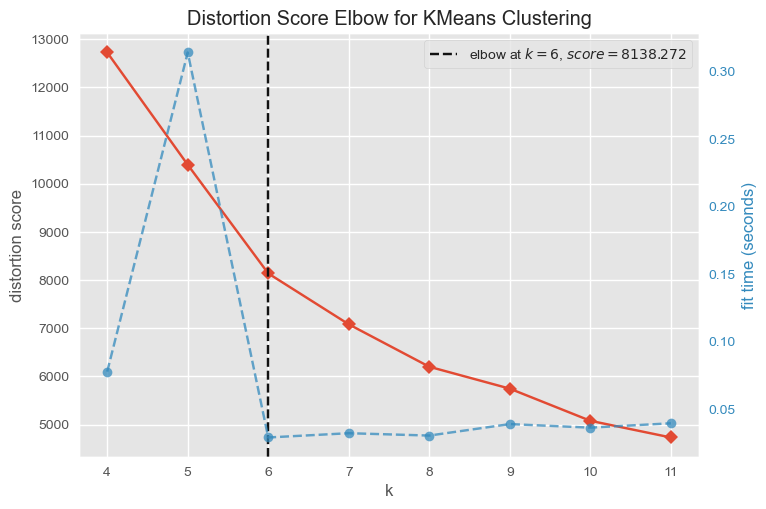

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
# Your code here...
visualizer = KElbowVisualizer(KMeans(n_init=2), k=(4,12), metric='distortion')

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.show()

## Another Way to Visualize Clustering Performance
The Silhouette Coefficient is used when the ground-truth about the dataset is unknown and computes the density of clusters computed by the model. The score is computed by averaging the silhouette coefficient for each sample, computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. This produces a score between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering. (http://www.scikit-yb.org/en/latest/api/cluster/silhouette.html)


### Your Turn!
Using the YellowBrick `SilhouetteVisualizer`, try visualizing models with various values of `K`.

**Note**:  This visualization is quite expensive, so I recommend performing this using a sample o your original data.

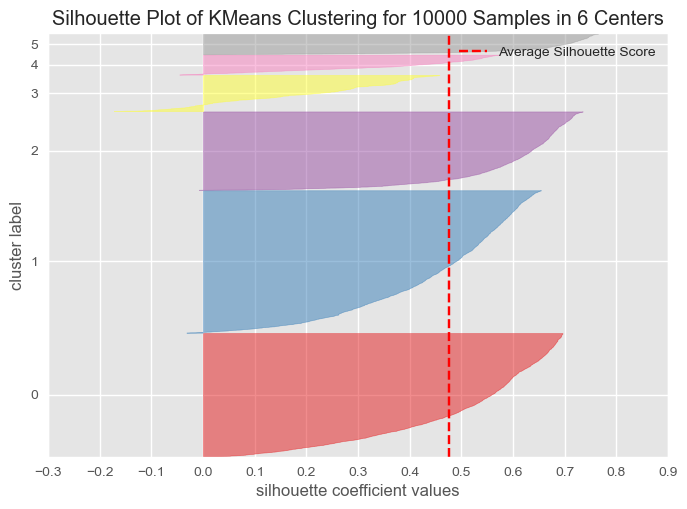

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
# Your code here...
visualizer = SilhouetteVisualizer( KMeans(n_clusters=6, n_init=3))

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.show()

## Anomaly Detection using Clustering methods
Let's use a hierarchical clustering method to detect anomalies in a set of data points. The one we will use is called (agglomerative clustering)[https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html]. 

First we will create a dataset that only has 20 DGA rows and 1000 legit samples. Thus, there are 20 anomalies in this dataset that we know of. Then we will see if our clustering method can detect them. 

In [22]:
dga_data = pd.read_csv('../data/dga_features_final_df_domain.csv')
print(dga_data.isDGA.value_counts())

isDGA
dga      1000
legit    1000
Name: count, dtype: int64


In [26]:
is_dga = dga_data[dga_data['isDGA']=='dga'].sample(10)
not_dga = dga_data[dga_data['isDGA']=='legit']

In [27]:
print(len(is_dga))
print(len(not_dga))

10
1000


In [28]:
dga_anomaly_data = pd.concat([is_dga, not_dga])
dga_anomaly_data['isDGA'].value_counts()

isDGA
legit    1000
dga        10
Name: count, dtype: int64

In [29]:
dga_anomaly_data_domain = dga_anomaly_data
dga_anomaly_data = dga_anomaly_data.drop('domain',axis=1)

#### Now use this dataset in clustering

First we want to scale the data because it is clustering which means that distance is important and that is extremely sensitive to different scales. Use either the Standard Scaler or Min Max Scaler from sklearn to scale our data set.

In [30]:
dga_anomaly_data  = StandardScaler().fit_transform(dga_anomaly_data)

ValueError: could not convert string to float: 'dga'

Now that we have prepared the data, we can put it into a model. Call the Agglomerative Clustering model from sklearn and fit it to the data. name the model **agglomerative_clust**

In [ ]:
agglomerative_clust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# Your code here
agglomerative_clust = agglomerative_clust.fit(dga_anomaly_data)

# pull out the label of the cluster each point belongs to. 
labels_for_clusters = agglomerative_clust.labels_

This plot_dendrogram function will plot the dendrogram for the cluster model you just fitted to the data. 

In [24]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Use the plot_dendrogram function to plot the dendrogram. You an get lower and lower levels if you increase the value of **p**. Try plotting a few values of **p** to see the difference and notice what happens.

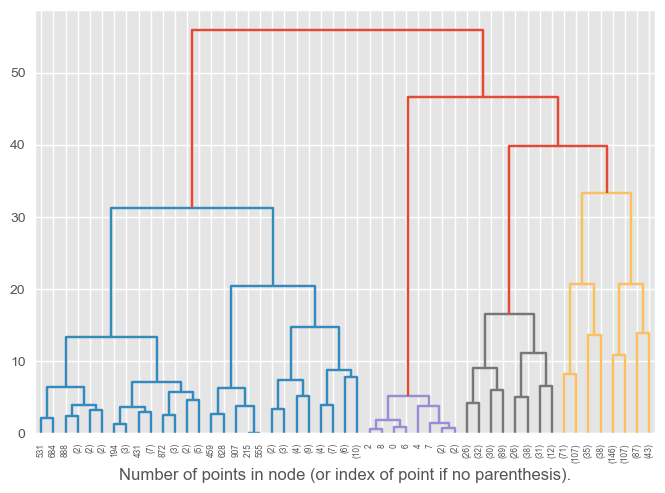

In [87]:
plot_dendrogram(agglomerative_clust, truncate_mode="level", p=5);
plt.xlabel("Number of points in node (or index of point if no parenthesis).");


Notice that in the plot there are some digits on the x-axis with no parenthesis. These are nodes that did not have more than 1 data point. We want to take a look at these because they are 'far' enough away from the rest of the data to warrant their own node, and thus could be an anomaly. 

Below, use the original pandas data frame to print the rows of the single nodes and see if these are our few DGAs. 

In [25]:
dga_anomaly_data_domain.iloc[0,:]

NameError: name 'dga_anomaly_data_domain' is not defined

In [71]:
dga_anomaly_data_domain.iloc[3,:]

isDGA                                       1
domain             15ihbm71utcnfa8dk1mmgoobl9
length                                     26
digits                                      7
entropy                              4.180833
vowel-cons                           0.357143
firstDigitIndex                             1
ngrams                             682.269402
Name: 3, dtype: object

In [90]:
dga_anomaly_data_domain.iloc[5,:]

isDGA                            1
domain             uyphoykvvmxetnf
length                          15
digits                           0
entropy                   3.640224
vowel-cons                    0.25
firstDigitIndex                  0
ngrams                  779.403541
Name: 970, dtype: object

In [89]:
dga_anomaly_data_domain.iloc[29,:]

isDGA                         0
domain             skidrowgames
length                       12
digits                        0
entropy                3.418296
vowel-cons                  0.5
firstDigitIndex               0
ngrams               1337.05303
Name: 1019, dtype: object

Another thing to note is just to look at the contents of the smallest cluster (depending on how small you think your anomalies are. IN this case our smallest cluster contains the DGAs. Thus, our model accurately pulled out the DGAs into their own 'anomaly' cluster. 

## DBSCAN
Another clustering method we can try is DBSCAN (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).  Remember that the main tuning parameters for DBSCAN are:

* **epsilon (eps)**:  The minimum distance between two samples 
* **min_samples**:  The minimum number of samples needed to form a neighborhood

By default epsilon is 0.5 and the min_samples is 5. First, try DBSCAN with the default options.  If you use the `fit_predict()` function, you can save the results in a new column in your data.  

How did this compare with K-Means?  Given that you actually know what the data really is, how did DBSCAN do in terms of identifing meaningful clusters?  Look at the `dsrc` column and do `value_counts()` for the various neighhborhoods.  What did you notice?

Try again, but this time experiment with the values of epsilon and min_samples and see what DBSCAN comes up with. 

In [23]:
dbscan = DBSCAN(min_samples=50)

In [24]:
final_data['dbs_default'] = dbscan.fit_predict(final_data[scaled_feature_columns])

In [25]:
final_data['dbs_default'].value_counts()

 1    39301
 2     9973
 0     2500
-1      284
 4      259
 3      116
 5       45
Name: dbs_default, dtype: int64

In [26]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: dsrc, dtype: int64

In [27]:
final_data[final_data['dbs_default'] == 1 ][['dsrc','domain']].sample(10)

,dsrc,domain
9446,cryptolocker,xvbnapiywfagvt
23140,necurs,huwvtreromwta
2731,cryptolocker,hufqjcrmgchih
41248,nivdort,whomwhole
35529,nivdort,thesefeel
6953,cryptolocker,bdtakobikoni
5404,cryptolocker,xiuadnbellohhw
28650,necurs,ngqhqqbduvjkdr
38321,nivdort,dreamgrow
7461,cryptolocker,lligwhttuxyqir


In [28]:
final_data[final_data['dbs_default'] == -1 ]['dsrc'].sample(10)

50809      alexa
49624      alexa
51698      alexa
43531      alexa
52446      alexa
2405     bamital
46545      alexa
47868      alexa
52264      alexa
49046      alexa
Name: dsrc, dtype: object

In [29]:
final_data['domain'][final_data['dsrc'] == "nivdort"].sample(5)

40241    drinkvoice
42410     fairfruit
39274      rockslow
38547      gladjune
40724     headthrow
Name: domain, dtype: object

In [30]:
final_data[final_data['dbs_default'] == 2 ]['dsrc'].value_counts()

gameoverdga    9973
Name: dsrc, dtype: int64

In [31]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: dsrc, dtype: int64

In [32]:
final_data[final_data['dsrc'] == "cryptolocker"]['domain'].sample(10)

10649       wbirarkhsfgf
8792        ffkwsvsieexl
11876      gkjsqegicfuxs
7565       btahdqypypsbp
12072     xjlepuhmjvycjt
8145     gxaakkrvirymuuk
11432    qnvysekkbpwpnmo
3825        qmvuvtftlhws
7031        hgttabqebluy
5041        iyiwxusxdvke
Name: domain, dtype: object

In [33]:
final_data[final_data['dsrc'] == "necurs"]['domain'].sample(10)

32316          ptgctebbvohb
31865    vwhilgweujpuliijvs
26512     ksyaqkudmuorqdsnx
30930           kmtleqvxqvk
24248     rtatnpxrleuyjfvmr
27666     rlgawlqrvgkskeisa
24989            uegqqmllfr
22616          defellojyrqw
22599            jhkoqfmwjo
26324     vrdimsspkhpbyvwjo
Name: domain, dtype: object